In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from google.colab import auth
from google.auth import default
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/drive')

creds, _ = default()
gc = gspread.authorize(creds)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
columns = ['Fact Checked Claim Index', 'Podcast Claim Index', 'Cosine Similarity Score']
fact_checked_claims_fp = '/drive/My Drive/DSN/matched_claims_context_2.txt'
claims_df = pd.read_csv(fact_checked_claims_fp, names = columns)
sorted_mc_df = claims_df.sort_values(by=['Cosine Similarity Score'], ascending=False)[:len(claims_df)]

In [25]:
kb_claims_filepath = '/drive/MyDrive/DSN/politifact_filtered_noflips.csv'
#podcast_claims_filepath = '/drive/MyDrive/DSN/transcript_claims_context_2.tsv'
podcast_claims_filepath = '/drive/MyDrive/spotify-misinformation/preprocessing-output/podcast_claims_context_2_reupload.tsv'

matched_claims_filepath = '/drive/MyDrive/DSN/matched_claims_context_2.txt'
#podcast_claims_filepath = '/drive/MyDrive/DSN/matched_claims_context_2.txt'

# utility functions to read data

claims_df = pd.read_csv(kb_claims_filepath)

"""

pc_claims = []

# with open(podcast_claims_filepath, 'r') as all_transcripts:
#   for idx, line in enumerate(all_transcripts):
#     # split_line = line.strip().split("\t")
#     pc_claims.append(line.strip().split("\t"))

with open(podcast_claims_filepath, 'r') as all_transcripts:
  for idx, line in enumerate(all_transcripts):
    #split_line = line.strip().split("\t")
    pc_claims.append(line.strip().split("\t"))
"""

def get_kb_claim(kb_idx):
  return claims_df['Statement'][int(kb_idx)]

def get_pc_claim(pc_idx):
  return ".".join(pc_claims[int(pc_idx)][2:])

def get_kb_claim_date(kb_idx):
  return claims_df['Date'][int(kb_idx)]

def get_center_claim(pc_idx):
  return pc_claims[int(pc_idx)][4]

def get_show_uri(pc_idx):
  return pc_claims[int(pc_idx)][0]

def get_ep_uri(pc_idx):
  return pc_claims[int(pc_idx)][1]

In [29]:
def get_full_df(raw_claims_df, labeled_df):

  """
  Retrieve show/episode (URI) metadata from pairs that have been annotated

  raw_claims_df: Pandas df object - (larger) dataset containing unmatched claims
  labeled_df: Pandas df object - (smaller) dataset with annotated samples
  """

  raw_claims_df = raw_claims_df.reset_index()
  raw_claims_df['Stance Agreement'] = -1 # Initialize all as unlabeled, get labels from annotations below

  tuples_3d_list = []
  for i in range(0,len(labeled_df)):
    tuple_3d = (labeled_df['Fact Checked Claim Index'][i], labeled_df['Podcast Claim Index'][i], labeled_df['Stance Agreement'][i])
    tuples_3d_list.append(tuple_3d)

    claim_idx = tuples_3d_list[i][0]
    podcast_idx = tuples_3d_list[i][1]
    pair_stance = tuples_3d_list[i][2]

    # Getting corresponding row
    row_idx = raw_claims_df[(raw_claims_df['Podcast Claim Index'] == podcast_idx)].index.tolist()

    raw_claims_df['Stance Agreement'][row_idx] = pair_stance
  
  return raw_claims_df

In [22]:
podcast_claims_filepath = '/drive/MyDrive/spotify-misinformation/preprocessing-output/podcast_claims_context_2_reupload.tsv'
pc_claims_concat = []

with open(podcast_claims_filepath, 'r') as all_transcripts:
  for idx, line in enumerate(all_transcripts):
    pc_claims_concat.append(line.strip().split("\t"))
    pc_claims_concat[idx][2] = ".".join(pc_claims_concat[int(idx)][2:])
    del pc_claims_concat[idx][3:]

In [45]:
raw_claims_df['Podcast Claim Index'] = np.arange(len(raw_claims_df))
len(raw_claims_df)

12486207

# Distribution for all pairs in original dataset 

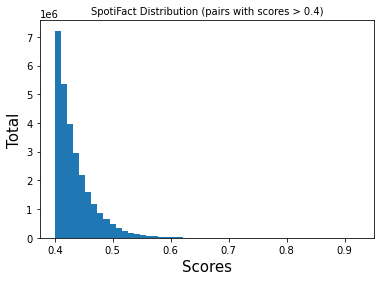

In [96]:
plt.hist(sorted_mc_df['Cosine Similarity Score'], bins = 50)
plt.title('SpotiFact Distribution (pairs with scores > 0.4)', fontsize=10)
plt.xlabel('Scores', fontsize=15)
plt.ylabel('Total', fontsize=15)
plt.savefig('/drive/My Drive/DSN/distribution-full-dataset.png', dpi=500)

# Distribution for top 10k pairs

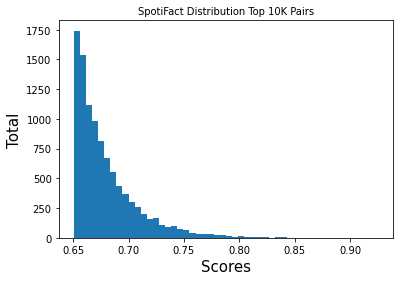

In [97]:
top_10k_df = sorted_mc_df[:10000]
plt.hist(top_10k_df['Cosine Similarity Score'], bins = 50)
plt.title('SpotiFact Distribution Top 10K Pairs', fontsize=10)
plt.xlabel('Scores', fontsize=15)
plt.ylabel('Total', fontsize=15)
plt.savefig('/drive/My Drive/DSN/distribution-10k.png', dpi=500)

In [26]:
def df_from_google_sheets(path, columns):

  """
  Get a pandas dataframe object from Google Sheets
  """

  worksheet = gc.open(path).sheet1
  rows = worksheet.get_all_values()
  rows = [x[:5] for x in rows]

  return pd.DataFrame.from_records(rows[1:], columns=columns)

def get_labels(matched_claims_df, k, labeled_df):

  """
  Retrieve labels from pairs that have been annotated

  matched_claims_df: Pandas df object - (larger) dataset containing pairs 
  k: top k desired samples from claims_df
  labeled_df: Pandas df object - (smaller) dataset with annotated samples
  """

  top_k_df = matched_claims_df[:k]
  top_k_df = top_k_df.reset_index()
  top_k_df['Stance Agreement'] = -1 # Initialize all as unlabeled, get labels from annotations below
  top_k_df_copy = top_k_df.copy()

  tuples_3d_list = []
  for i in range(0,len(labeled_df)):
    tuple_3d = (labeled_df['Fact Checked Claim Index'][i], labeled_df['Podcast Claim Index'][i], labeled_df['Stance Agreement'][i])
    tuples_3d_list.append(tuple_3d)

    claim_idx = tuples_3d_list[i][0]
    podcast_idx = tuples_3d_list[i][1]
    pair_stance = tuples_3d_list[i][2]

    # Getting corresponding row
    row_idx = top_k_df[(top_k_df['Fact Checked Claim Index'] == claim_idx) & (top_k_df['Podcast Claim Index'] == podcast_idx)].index.tolist()

    top_k_df['Stance Agreement'][row_idx] = pair_stance
  
  return top_k_df

# Importing Labeled Data

In [27]:
# Load manually labeled data
labeling_phase = 'top_3000_context_2_single_sentence_'
column_names = ['Fact Checked Claim Index', 'Podcast Claim Index', 'Fact Checked Claim', 'Podcast Claim', 'Stance Agreement']

labeled_path = '/drive/My Drive/spotify-misinformation/labeling-output/manually-labeled-matched-pairs.csv'
labeled_df_2021 = pd.read_csv(labeled_path)

omar_individual = df_from_google_sheets('top_3000_context_2_single_sentence_omar_individual', columns=column_names)
omar_individual_data = omar_individual[200:800].copy()
jon_individual = df_from_google_sheets('top_3000_context_2_single_sentence_jon_individual', columns=column_names)
jon_individual_data = jon_individual[200:800].copy()
"""
#abhijeet_individual = df_from_google_sheets('top_3000_context_2_single_sentence_abhijeet_individual', columns=column_names)
#abhijeet_individual_data = abhijeet_individual[200:800].copy()
"""
frames = [labeled_df_2021, omar_individual_data, jon_individual_data]
labeled_df = pd.concat(frames)

labeled_df = labeled_df.drop(['Fact Checked Claim', 'Podcast Claim'], axis=1)
labeled_df.to_csv('/drive/My Drive/spotifact-labeled-data-omar-jon.csv') 
labeled_path_2 = '/drive/My Drive/spotifact-labeled-data-omar-jon.csv'
labeled_df = pd.read_csv(labeled_path_2)
#labeled_df = labeled_df.drop(labeled_df[labeled_df['Stance Agreement']==-1].index) # Abhijeet's unlabeled data
#labeled_df[['Stance Agreement']] = labeled_df[['Stance Agreement']].astype('int')
labeled_df.head()

,Unnamed: 0,Fact Checked Claim Index,Podcast Claim Index,Stance Agreement
0,0,15673,13337,5
1,1,15508,2494200,2
2,2,912,3078202,5
3,3,18351,4160261,5
4,4,7041,10930884,3


# Distributions from top 3000 of labeled and unlabeled data (2021 + 2022)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


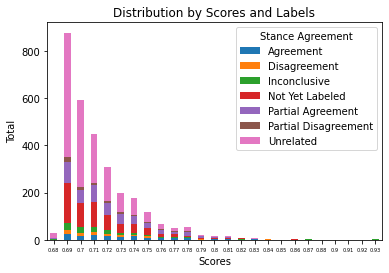

In [100]:
# Get labels for top 3k pairs of similarity scores
top_3k_df = get_labels(sorted_mc_df, 3000, labeled_df)

# For Plot Legend
top_3k_df.loc[top_3k_df["Stance Agreement"] == -1, "Stance Agreement"] = "Not Yet Labeled"
top_3k_df.loc[top_3k_df["Stance Agreement"] == 1, "Stance Agreement"] = "Agreement"
top_3k_df.loc[top_3k_df["Stance Agreement"] == 2, "Stance Agreement"] = "Partial Agreement"
top_3k_df.loc[top_3k_df["Stance Agreement"] == 3, "Stance Agreement"] = "Disagreement"
top_3k_df.loc[top_3k_df["Stance Agreement"] == 4, "Stance Agreement"] = "Partial Disagreement"
top_3k_df.loc[top_3k_df["Stance Agreement"] == 5, "Stance Agreement"] = "Unrelated"
top_3k_df.loc[top_3k_df["Stance Agreement"] == 6, "Stance Agreement"] = "Inconclusive"

top_3k_df = top_3k_df.drop(['index', 'Fact Checked Claim Index', 'Podcast Claim Index'], axis=1)
decimals = 2
top_3k_df['Cosine Similarity Score'] = top_3k_df['Cosine Similarity Score'].apply(lambda x: round(x, decimals))
dfp = top_3k_df.pivot_table(index='Cosine Similarity Score', columns=['Stance Agreement'], aggfunc=len)

# Plot the dataframe
dfp.plot(kind='bar', stacked=True, ylabel='Total', xlabel='Scores',
         title='Distribution by Scores and Labels', rot=0)
plt.xticks(fontsize=5)
plt.savefig('/drive/My Drive/DSN/distribution-labeled-3k.png', dpi=500)

# Distribution for Total Labeled Data including Predictions (2022)

In [101]:
# Include 2022 predictions data for analysis
omar_predictions_data = df_from_google_sheets('spotifact-predictions-labeling-omar', columns=column_names)
omar_predictions_data_2 = df_from_google_sheets('spotifact-predictions-labeling-omar-2', columns=column_names)
omar_predictions_data_retrain = df_from_google_sheets('spotifact-predictions-labeling-omar-retrain', columns=column_names)
frames = [labeled_df, omar_predictions_data, omar_predictions_data_2, omar_predictions_data_retrain]
total_labeled_df = pd.concat(frames) # Concatenated df with overlap and recent Jon (Omar) and Omar's 2022 labels
total_labeled_df = total_labeled_df.reset_index()
total_labeled_df = total_labeled_df.drop(['index', 'Fact Checked Claim', 'Podcast Claim'], axis=1)
total_labeled_df.to_csv('/drive/My Drive/spotifact-labeled-data-2022.csv') 
labeled_path = '/drive/My Drive/spotifact-labeled-data-2022.csv'
total_labeled_df = pd.read_csv(labeled_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


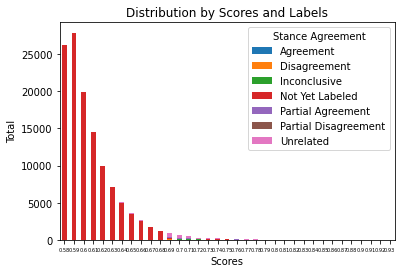

In [102]:
# Get labels for top 123k pairs of similarity scores
top_123k_df = get_labels(sorted_mc_df, 123000, total_labeled_df)

# For Plot Legend
top_123k_df.loc[top_123k_df["Stance Agreement"] == -1, "Stance Agreement"] = "Not Yet Labeled"
top_123k_df.loc[top_123k_df["Stance Agreement"] == 1, "Stance Agreement"] = "Agreement"
top_123k_df.loc[top_123k_df["Stance Agreement"] == 2, "Stance Agreement"] = "Partial Agreement"
top_123k_df.loc[top_123k_df["Stance Agreement"] == 3, "Stance Agreement"] = "Disagreement"
top_123k_df.loc[top_123k_df["Stance Agreement"] == 4, "Stance Agreement"] = "Partial Disagreement"
top_123k_df.loc[top_123k_df["Stance Agreement"] == 5, "Stance Agreement"] = "Unrelated"
top_123k_df.loc[top_123k_df["Stance Agreement"] == 6, "Stance Agreement"] = "Inconclusive"

top_123k_df = top_123k_df.drop(['index', 'Fact Checked Claim Index', 'Podcast Claim Index'], axis=1)
decimals = 2
top_123k_df['Cosine Similarity Score'] = top_123k_df['Cosine Similarity Score'].apply(lambda x: round(x, decimals))
dfp = top_123k_df.pivot_table(index='Cosine Similarity Score', columns=['Stance Agreement'], aggfunc=len)

# Plot the dataframe
dfp.plot(kind='bar', stacked=True, ylabel='Total', xlabel='Scores',
         title='Distribution by Scores and Labels', rot=0)
plt.xticks(fontsize=5)
plt.savefig('/drive/My Drive/DSN/distribution-labeled-123k.png', dpi=500)

# Precision/Recall Analysis of Classifier

In [103]:
# Precision 
rd1_precision = (omar_predictions_data['Stance Agreement'].value_counts()[2] + 
                 omar_predictions_data['Stance Agreement'].value_counts()[3])/(len(omar_predictions_data))
rd2_precision = (omar_predictions_data_2['Stance Agreement'].value_counts()[1] + 
                 omar_predictions_data_2['Stance Agreement'].value_counts()[3])/(len(omar_predictions_data_2))
retrain_precision = (omar_predictions_data_retrain['Stance Agreement'].value_counts()[1]
                     + omar_predictions_data_retrain['Stance Agreement'].value_counts()[3])/(len(omar_predictions_data_retrain))
print("Precision after 1 round of AL: ", rd1_precision)
print("Precision after 2 rounds of AL: ", rd2_precision)
print("Precision after 3 rounds of AL:", retrain_precision)

Precision after 1 round of AL:  0.1897810218978102
Precision after 2 rounds of AL:  0.2054794520547945
Precision after 3 rounds of AL: 0.28205128205128205
